In [3]:


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Project/Dataset/edata.csv')

In [6]:
df.head()

,Lat,Lon,Mag,Depth km,Timestamp,Region
0,36.1657,69.8792,4.0,115.08,1.491588e+09,HINDU KUSH REGION- AFGHANISTAN
1,14.4749,93.0560,5.3,33.64,1.491411e+09,ANDAMAN ISLANDS- INDIA REGION
2,36.1320,71.3585,4.9,102.03,1.491342e+09,AFGHANISTAN-TAJIKISTAN BORD REG.
3,36.3580,68.9443,4.6,32.17,1.491101e+09,HINDU KUSH REGION- AFGHANISTAN
4,36.5656,70.0559,4.0,229.25,1.490999e+09,HINDU KUSH REGION- AFGHANISTAN


In [7]:
# Select necessary columns
selected_columns = ['Timestamp', 'Mag', 'Lat', 'Lon', 'Depth km']
df = df[selected_columns]

In [8]:
df.head()

,Timestamp,Mag,Lat,Lon,Depth km
0,1.491588e+09,4.0,36.1657,69.8792,115.08
1,1.491411e+09,5.3,14.4749,93.0560,33.64
2,1.491342e+09,4.9,36.1320,71.3585,102.03
3,1.491101e+09,4.6,36.3580,68.9443,32.17
4,1.490999e+09,4.0,36.5656,70.0559,229.25


In [9]:
# Ensure correct data types
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values(by='Timestamp')  # Ensure chronological order

In [10]:
# Handle missing values
df.dropna(inplace=True)

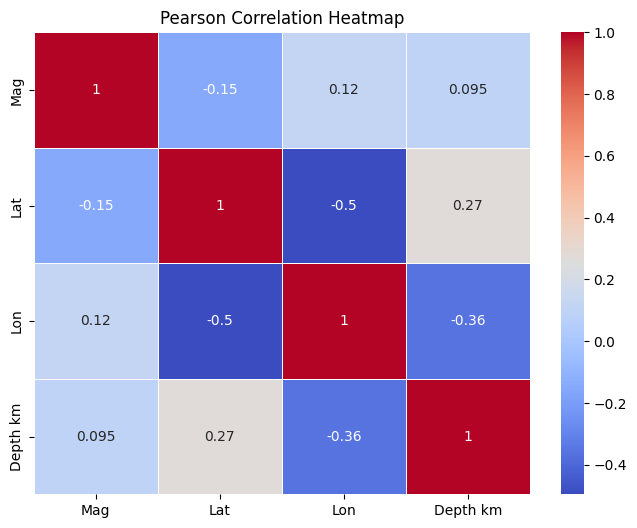

In [11]:
# Pearson Correlation and Heatmap
plt.figure(figsize=(8, 6))
corr_matrix = df[['Mag', 'Lat', 'Lon', 'Depth km']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Pearson Correlation Heatmap')
plt.show()


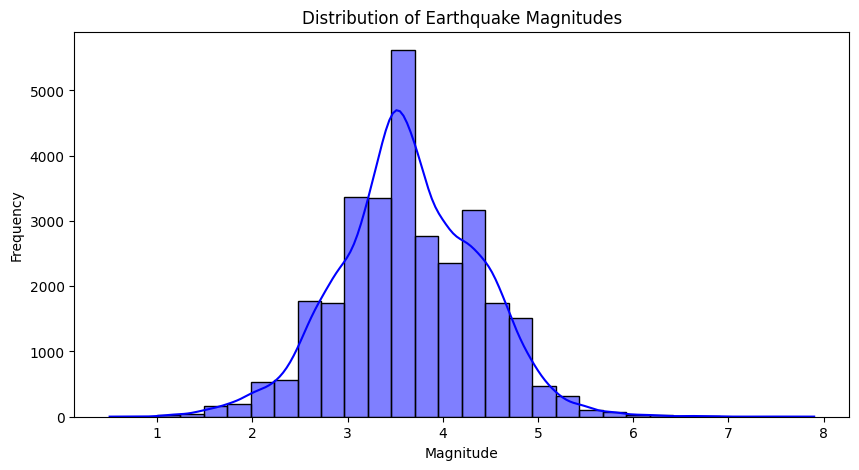

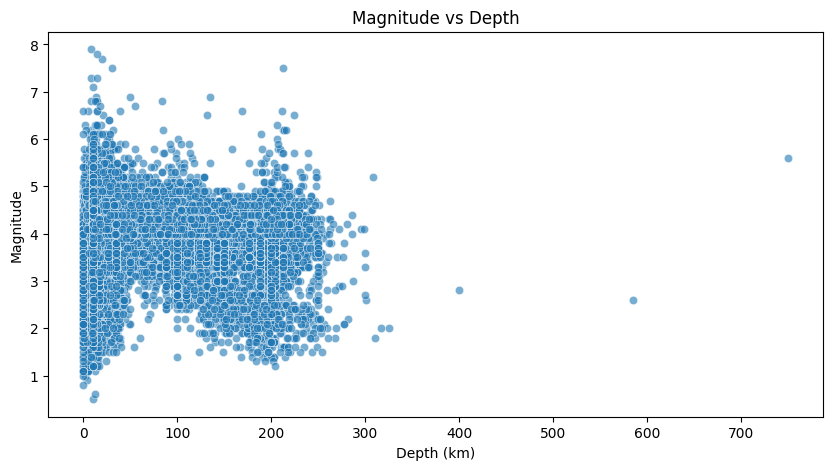

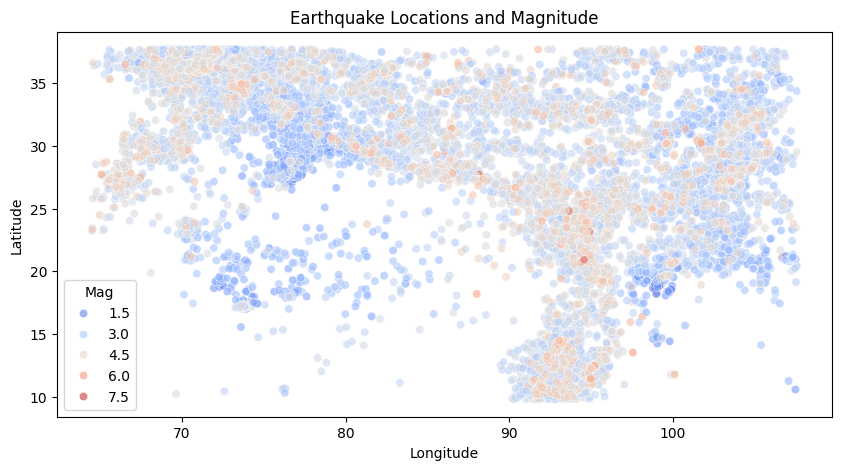

In [12]:
# Additional Data Visualizations
plt.figure(figsize=(10, 5))
sns.histplot(df['Mag'], bins=30, kde=True, color='blue')
plt.title('Distribution of Earthquake Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['Depth km'], y=df['Mag'], alpha=0.6)
plt.title('Magnitude vs Depth')
plt.xlabel('Depth (km)')
plt.ylabel('Magnitude')
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['Lon'], y=df['Lat'], hue=df['Mag'], palette='coolwarm', alpha=0.6)
plt.title('Earthquake Locations and Magnitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [13]:
# Feature Scaling
feature_scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaler = MinMaxScaler(feature_range=(-1, 1))

scaled_features = ['Lat', 'Lon', 'Depth km']
df[scaled_features] = feature_scaler.fit_transform(df[scaled_features])
df[['Mag']] = target_scaler.fit_transform(df[['Mag']])

In [14]:
# Prepare data for LSTM
def create_sequences(data, target_column, sequence_length=10):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i+sequence_length].values)
        y.append(data.iloc[i+sequence_length][target_column])
    return np.array(X), np.array(y)

In [15]:

# Define target variable
target_column = 'Mag'  # Predicting Magnitude
sequence_length = 30 # Use last 10 observations

In [16]:
X, y = create_sequences(df[scaled_features + ['Mag']], target_column, sequence_length)


In [17]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [18]:
# Build LSTM Model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [19]:
model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])


In [20]:
# Train the model
history = model.fit(X_train, y_train, epochs=4, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/4
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0348 - mean_absolute_error: 0.1442 - val_loss: 0.0350 - val_mean_absolute_error: 0.1367
Epoch 2/4
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0333 - mean_absolute_error: 0.1413 - val_loss: 0.0324 - val_mean_absolute_error: 0.1307
Epoch 3/4
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0329 - mean_absolute_error: 0.1399 - val_loss: 0.0309 - val_mean_absolute_error: 0.1229
Epoch 4/4
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0325 - mean_absolute_error: 0.1397 - val_loss: 0.0316 - val_mean_absolute_error: 0.1258


In [21]:
# Save the model
model.save('/content/drive/MyDrive/Project/Code/earthquake-master/Model/lstm_earthquake_model.keras')

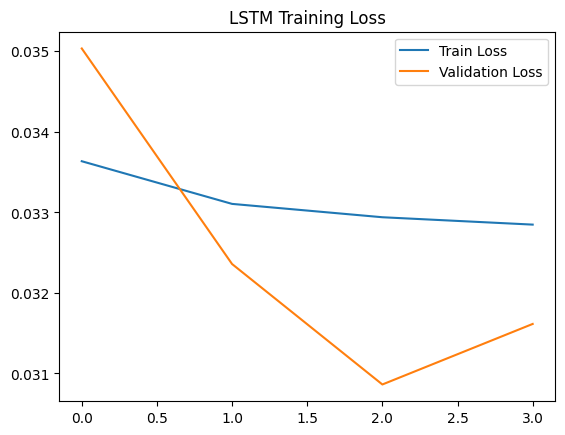

In [22]:
# Plot training loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('LSTM Training Loss')
plt.show()

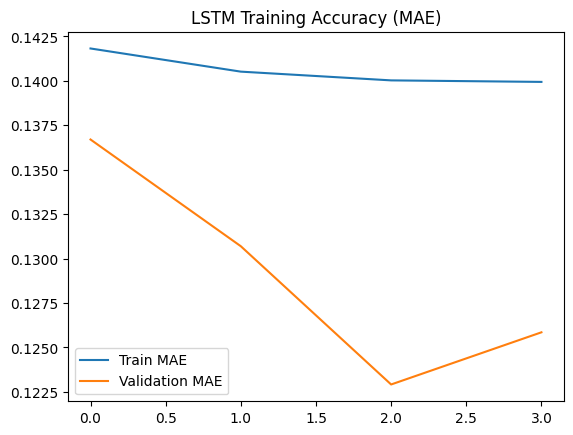

In [23]:
# Plot training accuracy
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.legend()
plt.title('LSTM Training Accuracy (MAE)')
plt.show()

In [24]:
# Make predictions
y_pred = model.predict(X_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [25]:
# Inverse transform the predictions and actual values to the original scale
y_pred_original = target_scaler.inverse_transform(y_pred)
y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1))

In [26]:
# Display the predictions and actual values side-by-side
comparison_df = pd.DataFrame({'Actual': y_test_original.flatten(), 'Prediction': y_pred_original.flatten()})
print(comparison_df)





      Actual  Prediction
0        3.2    3.500522
1        3.5    3.519035
2        3.2    3.507536
3        2.9    3.469492
4        3.5    3.429996
...      ...         ...
5990     4.0    4.053442
5991     4.6    3.999618
5992     4.9    4.068532
5993     5.3    4.150812
5994     4.0    4.267684

[5995 rows x 2 columns]


In [27]:
# Convert to classification labels based on magnitude ranges
threshold = 5.0  # Example threshold for classifying magnitudes
y_test_class = (y_test_original >= threshold).astype(int)
y_pred_class = (y_pred_original >= threshold).astype(int)

In [28]:
# Classification report
print("Classification Report:\n", classification_report(y_test_class, y_pred_class))



Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97      5596
           1       0.00      0.00      0.00       399

    accuracy                           0.93      5995
   macro avg       0.47      0.50      0.48      5995
weighted avg       0.87      0.93      0.90      5995



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


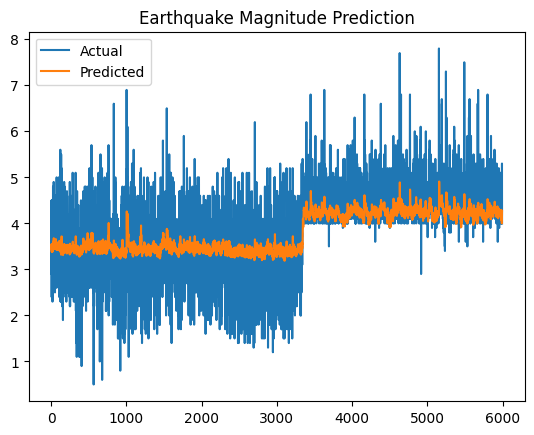

In [29]:
# Plot results
plt.plot(y_test_original, label='Actual')
plt.plot(y_pred_original, label='Predicted')
plt.legend()
plt.title('Earthquake Magnitude Prediction')
plt.show()

In [30]:
!pip install folium
import folium # Import the folium library
from folium.plugins import HeatMap
# Geospatial Visualization using Folium
map_center = [df['Lat'].mean(), df['Lon'].mean()]
earthquake_map = folium.Map(location=map_center, zoom_start=5)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Lat'], row['Lon']],
        radius=row['Mag'] * 2,
        color='red' if row['Mag'] > 5 else 'blue',
        fill=True,
        fill_color='red' if row['Mag'] > 5 else 'blue',
        fill_opacity=0.6,
        popup=f"Magnitude: {row['Mag']:.2f}, Depth: {row['Depth km']} km"
    ).add_to(earthquake_map)

In [31]:
# Save the map to an HTML file
earthquake_map.save("/content/drive/MyDrive/Project/Code/earthquake-master/results/earthquake_map.html")
print("Geospatial map saved as earthquake_map.html")

Geospatial map saved as earthquake_map.html


In [32]:
df

,Timestamp,Mag,Lat,Lon,Depth km
30000,1970-01-01 00:00:01.020594726,-0.378378,-0.187578,-0.610836,-0.960000
29999,1970-01-01 00:00:01.020615074,-0.081081,0.909882,-0.672705,-0.728533
29998,1970-01-01 00:00:01.020618219,-0.162162,0.495326,-0.093074,-0.912000
29997,1970-01-01 00:00:01.020627014,-0.108108,0.864393,0.170986,-0.912000
29996,1970-01-01 00:00:01.020677531,-0.135135,0.764032,-0.575953,-0.781867
...,...,...,...,...,...
4,1970-01-01 00:00:01.490999368,-0.054054,0.917304,-0.742475,-0.388667
3,1970-01-01 00:00:01.491101291,0.108108,0.902432,-0.794108,-0.914213
2,1970-01-01 00:00:01.491342067,0.189189,0.886242,-0.681971,-0.727920
1,1970-01-01 00:00:01.491410677,0.297297,-0.665181,0.325846,-0.910293
